# Belief Networks -  Dat File Generator

This document creates a Dat File with the ratings of each expert, a NN output, and other metadata.

## Specify the output File Path and number of indices per class


In [21]:
import os

# Specify file path and number of examples of each class
output_file_path = os.path.join("data_files", "prediction_results_50_final.dat")  # Construct the file path

# Create a balanced subset of n*10 images, ensuring each digit 0-9 is represented equally
indices_per_class = 5 

### 0.1 - Loading the Ground Truth Image Set (MNIST).   

The Ground Truth Set will be   {Phi1, Phi2, Phin N} where N =10100.  
They will be obtained by using the test_images in the mnist data set.  
Note, we do not need their associated labels. We are simply using the image data.  

In [22]:
# Import Relevant Libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import csv
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import load_model
from scipy.optimize import minimize


# Importing the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### 0.2 - Loading Experts

If you have predefined experts, they can be loaded from here.  
Be sure to update the file paths as needed.


If you have experts to load,  
     Use the script below.  
Else   
      go to mnist_expert_generator.ipynb and follow that first. 

    
In Lieu of Human Experts, we will create 11 Models.  
10 will be considered experts and used to create the Belief Network.  
The 11th will be saved for later.

NB. Be sure to update the save location model_path = f"mnist_expert{epoch}.keras"  # Path to save the model

In [23]:
# List of model paths
model_paths = [f"mnist_experts/mnist_expert{i+1}.keras" for i in range(10)]
scores = []

# Loop to load, evaluate each model and print test accuracy
for i, path in enumerate(model_paths):
    model = load_model(path)  # Load model
    test_loss, test_acc = model.evaluate(test_images, test_labels)  # Evaluate model
    #print(f"Test accuracy of Expert {i+1}: {test_acc}")  # Print test accuracy
    scores.append(test_acc)  # Append test accuracy to scores list

print("The 10 experts have been loaded")
print (np.round(scores,2))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7779 - loss: 0.9191
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7926 - loss: 0.7698
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6521 - loss: 1.7768
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6155 - loss: 1.4973
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8506 - loss: 0.6878
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8963 - loss: 0.5285
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9368 - loss: 0.2546
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7133 - loss: 1.3220
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8402 - loss: 0.5313
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9448 - loss: 0.2935
The 10 experts have been loaded
[0.8  0.81 0.68 0.65 0.87 0.91 0.95 0.74 0.85 0.95]


# Part 1 - Probability Assessment

### 1.3 Weighted Self Assement : p~ component or " Expert Quality Score"

In [24]:
import numpy as np
from tensorflow.keras.models import load_model

# List of model paths

scores = []         # Scores is also used in section 2.11.8

# Loop to load, evaluate each model and print test accuracy
for i, path in enumerate(model_paths):
    model = load_model(path)  # Load model
    test_loss, test_acc = model.evaluate(test_images, test_labels)  # Evaluate model
    scores.append(test_acc)  # Append test accuracy to scores list

scores =np.round(scores,2)
print("The Quality Scores for each Expert is :", np.round(scores,3))
print("Scores in ascending order:", sorted(np.round(scores,3)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7779 - loss: 0.9191
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7926 - loss: 0.7698
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6521 - loss: 1.7768
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6155 - loss: 1.4973
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8506 - loss: 0.6878
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8963 - loss: 0.5285
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9368 - loss: 0.2546
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7133 - loss: 1.3220
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8402 - loss: 0.5313
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9448 - loss: 0.2935
The Quality Scores for each Expert is : [0.8  0.81 0.68 0.65 0.87 0.91 0.95 0.74 0.85 0.95]
Scores in ascending order: [0.65, 0.68, 0.74, 0.8, 0.81, 0.85, 0.87, 0.91, 0.95, 0.95]


### 1.4 Weighted Self Assement : V* component or " Self Certainty Score"

In this section, each expert is asked to provide a label "0,1,2,....9" to each image in the Ground Truth Data Set.  
Furthermore, the expert is asked to give their "Self Certainty Score".  

Since our experts are super human, we can use gradations of 0.01 instead of 0.3

Furthermore, instead of simply giving a reading of  
"Given Phi 1, Expert 1 assigns the label : 8, with a self certainty of: 0.11"  
Our experts give their self certainty for each possible label.:

"Given Phi 1, Expert 1 assigns the label : 0, with a self certainty of: 0.03"   
"Given Phi 1, Expert 1 assigns the label : 2, with a self certainty of: 0.05"     
...   
"Given Phi 1, Expert 1 assigns the label : 9, with a self certainty of: 0.15"  

You may want to use a smaller Ground Truth. 
Here has 10 photos of each class (digit).    
This is more realistic anyways, if the expertss were to be human. Can't overwork them.  
We are calculating the self certainty p~ for each expert below.  
   
All values below 0.1 are clipped. the remaining values are normalized.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


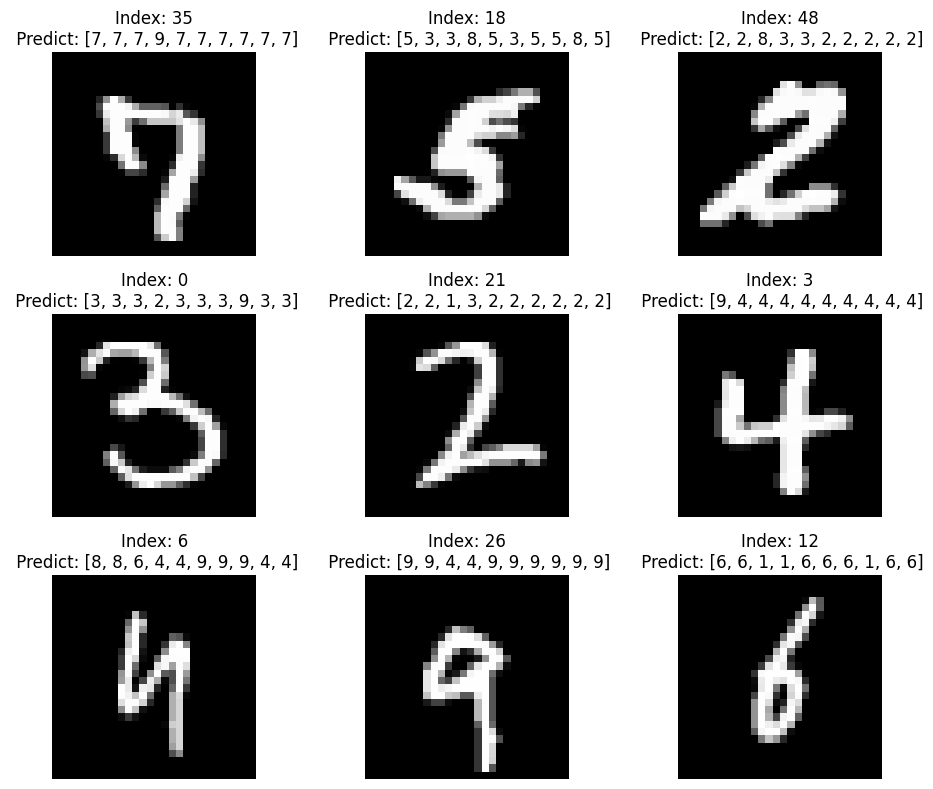


Index: 35
Expert 1 assigns the label: 7, with a self certainty of: 0.59
Expert 2 assigns the label: 7, with a self certainty of: 0.51
Expert 3 assigns the label: 7, with a self certainty of: 0.18
Expert 4 assigns the label: 9, with a self certainty of: 0.3
Expert 5 assigns the label: 7, with a self certainty of: 0.61
Expert 6 assigns the label: 7, with a self certainty of: 0.7
Expert 7 assigns the label: 7, with a self certainty of: 0.56
Expert 8 assigns the label: 7, with a self certainty of: 0.41
Expert 9 assigns the label: 7, with a self certainty of: 0.74
Expert 10 assigns the label: 7, with a self certainty of: 0.69

Index: 18
Expert 1 assigns the label: 5, with a self certainty of: 0.31
Expert 2 assigns the label: 3, with a self certainty of: 0.49
Expert 3 assigns the label: 3, with a self certainty of: 0.12
Expert 4 assigns the label: 8, with a self certainty of: 0.15
Expert 5 assigns the label: 5, with a self certainty of: 0.35
Expert 6 assigns the label: 3, with a self certai

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# True classes from the full test_labels
true_classes_full = np.argmax(test_labels, axis=1)

 
selected_indices = []

for digit in range(10):
    digit_indices = np.where(true_classes_full == digit)[0]
    selected_digit_indices = np.random.choice(digit_indices, indices_per_class, replace=False)
    selected_indices.extend(selected_digit_indices)

# Ensure the selected indices are shuffled to mix the digits # Not sure if this line is necessary tbh
np.random.shuffle(selected_indices)

# Slicing the test_images and test_labels to get only the selected subset
subset_test_images = test_images[selected_indices]
subset_test_labels = test_labels[selected_indices]

# Load models and get predictions
num_models = 10  # Specify the number of models
predictions = []
predicted_classes = []

for i in range(1, num_models + 1):
    model = load_model(f"mnist_experts/mnist_expert{i}.keras")  # Load each model
    pred = model.predict(subset_test_images)  # Predict with the model on the subset
    predictions.append(pred)
    predicted_classes.append(np.argmax(pred, axis=1))  # Convert softmax to class predictions

# True classes for the subset
true_classes = np.argmax(subset_test_labels, axis=1)

# Identify misclassified examples for each model
misclassified_by_model = [np.where(pred_classes != true_classes)[0] for pred_classes in predicted_classes]

# Count misclassifications for each image in the subset
misclassification_counts = {}
for model_misclassified_indices in misclassified_by_model:
    for index in model_misclassified_indices:
        misclassification_counts[index] = misclassification_counts.get(index, 0) + 1

# Sort indices by the number of times they were misclassified, in descending order
sorted_misclassified_indices = sorted(misclassification_counts, key=misclassification_counts.get, reverse=True)

# Display 9random images from misclassified indices in a 3x3 grid
random_misclassified_indices = np.random.choice(sorted_misclassified_indices, 16, replace=False)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))

for ax, index in zip(axes.flatten(), random_misclassified_indices):
    ax.imshow(subset_test_images[index].reshape(28, 28), cmap='gray')
    predictions_for_plot = [predicted_classes[i][index] for i in range(num_models)]  # Predictions from all models for this index
    ax.set_title(f"Index: {index}\n Predict: {predictions_for_plot}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print prediction and softmax output for each randomly selected misclassified index
for index in random_misclassified_indices:
    print()
    print(f"Index: {index}")
    for i in range(num_models):
        self_certainty = np.round(np.max(predictions[i][index]),2)
        print(f"Expert {i+1} assigns the label: {predicted_classes[i][index]}, with a self certainty of:" , self_certainty)


### Getting a New Image and a NN Softmax Output

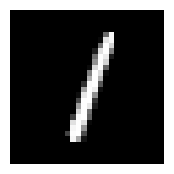

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[0.    0.943 0.018 0.017 0.    0.    0.    0.012 0.011 0.   ]]
1.001


In [26]:
# 1. Import Relevant Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.metrics import structural_similarity as compare_ssim

# 2. Load a new image to do forward pass
new_photo_index = np.max(selected_digit_indices)+2 # +12 is good example, +x is good counterexample
image_resized = test_images[new_photo_index]
image_resized = cv2.resize(image_resized, (28, 28))

# Display the image
plt.figure(figsize=(2, 2))
plt.imshow(image_resized, cmap='gray')
plt.axis('off')
plt.show()

# 3. Load the MNIST Expert (model 11)
model_path = 'mnist_experts/mnist_expert11.keras'  # Adjust this path to where your model is stored
mnist_expert11 =load_model(model_path)
guess = mnist_expert11.predict(image_resized.reshape(1, 28, 28, 1))
guess = np.round(guess,3)
print(guess)
print(np.sum(guess))

guess = np.array2string(guess).strip('[]')



### Writing Down to DAT File 

█(P ̃= successes/(# of trials)   ±1.95*(P̃*(1-P̃))#(1) )


In [27]:

def write_prediction_results(file_path, subset_test_images, num_models, predictions, scores, guess):

    with open(file_path, 'w') as file:
        # Write header
        file.write(f"{subset_test_images.shape[0]} \t {num_models} \t {subset_test_images.shape[0]*num_models} \n")
        file.write(f"0 \n")
        file.write(f"{guess} \n")

        # For each model, write prediction results for each image
        for j in range(len(subset_test_images)):
            for i in range(num_models):
                predicted_class = np.argmax(predictions[i][j])
                pred = np.round(predicted_class,2)
                softmax_output = np.max(predictions[i][j]) * scores[i]
                expert_accuracy = scores[i]

                # Write to file
                file.write(f"{i+1} \t  {j} \t   {predicted_class} \t {(softmax_output-(1.95*(np.array(scores[i])*(1-np.array(scores[i]))/10))):.4f} \t {softmax_output:.4f} \t {(softmax_output+(1.95*(np.array(scores[i])*(1-np.array(scores[i]))/10))):.4f} \n")

    print(f"Prediction results have been written to '{file_path}'.")


write_prediction_results(output_file_path, subset_test_images, num_models, predictions, scores, guess)

Prediction results have been written to 'data_files/prediction_results_50_final.dat'.


### Sanity Check - What does SSIM think?

This is all the SSIM scores
[0.016  0.0205 0.0185 0.0203 0.0184 0.018  0.0206 0.0183 0.0162 0.0181
 0.0161 0.0228 0.0267 0.0213 0.0186 0.032  0.019  0.0221 0.0189 0.0255
 0.0191 0.0237 0.0188 0.0267 0.0158 0.0184 0.0202 0.0154 0.021  0.016
 0.0194 0.0162 0.0237 0.0205 0.0205 0.0162 0.0178 0.0229 0.0193 0.0198
 0.0185 0.025  0.0218 0.0192 0.0192 0.0171 0.0281 0.0175 0.0174 0.017 ]
Highest phi index: 15, with phi value: 0.03196
Lowest of all phis 0.015363775542765351
Sum of all phi values 1.0


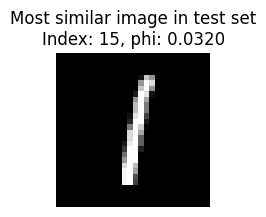

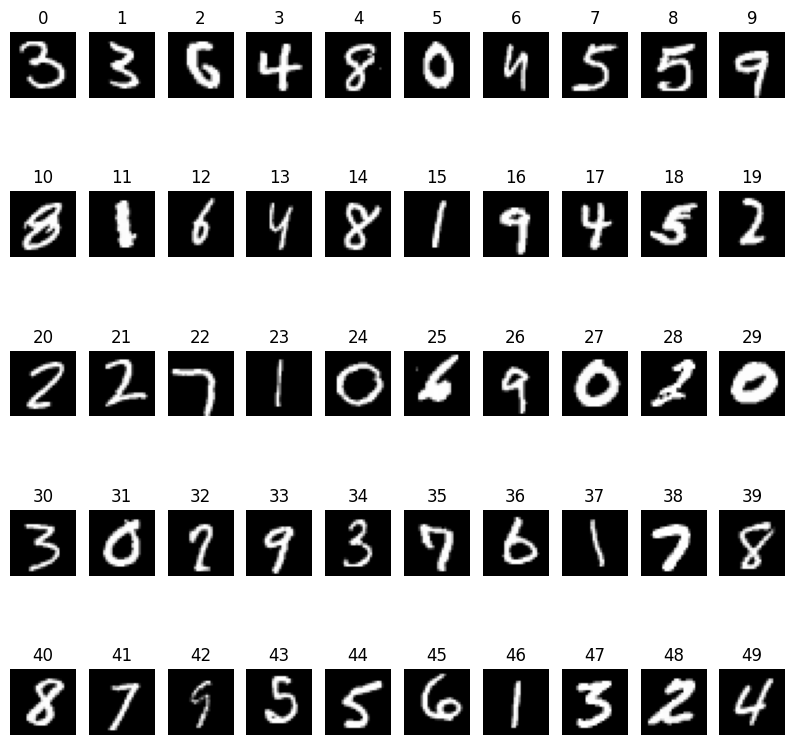

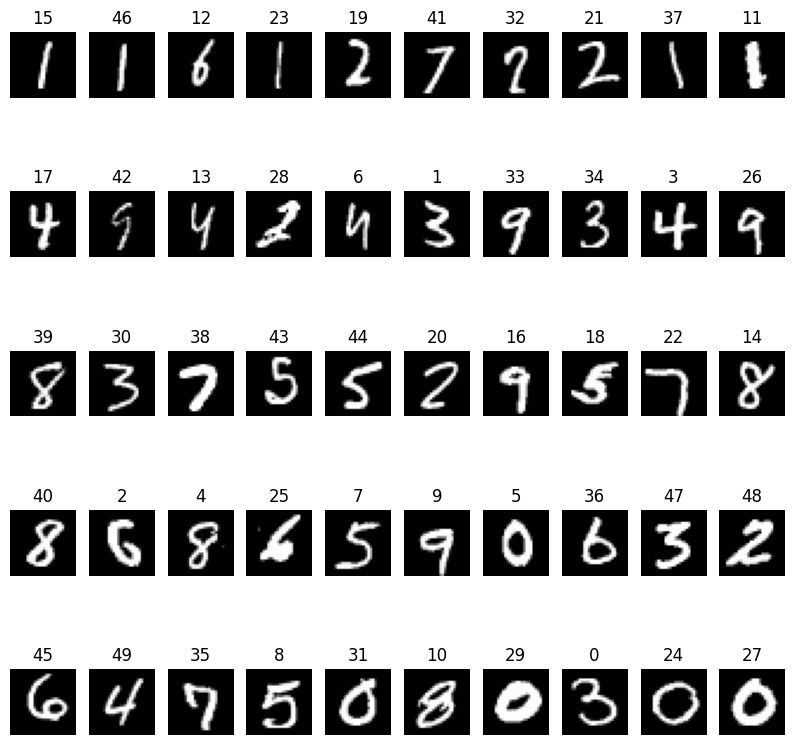

Label 0: Weighted sum = 0.0815
Label 1: Weighted sum = 0.1324
Label 2: Weighted sum = 0.1067
Label 3: Weighted sum = 0.0939
Label 4: Weighted sum = 0.1012
Label 5: Weighted sum = 0.0918
Label 6: Weighted sum = 0.0986
Label 7: Weighted sum = 0.1030
Label 8: Weighted sum = 0.0914
Label 9: Weighted sum = 0.0995
Max class 1
Second highest class: 2


In [28]:
#Get SSIM to each image in Belief Network
ssim_scores = []


for test_image in subset_test_images:
    # Resize the test image to 28x28
    test_image = cv2.resize(test_image, (28, 28))
    ssim2 = compare_ssim(image_resized, test_image, data_range=1)#data_range=test_image.max() - test_image.min())
    ssim_scores.append(ssim2)

# Use Softmax to convert from [-1,1] range to [0,1]
ssim_scores = np.exp(ssim_scores) / np.sum(np.exp(ssim_scores))
print('This is all the SSIM scores')
print(np.round(ssim_scores,4))

max_ssim_index = np.argmax(ssim_scores)
max_ssim_value = ssim_scores[max_ssim_index]
print(f"Highest phi index: {max_ssim_index}, with phi value: {np.round(max_ssim_value,5)}")
print("Lowest of all phis", ssim_scores[np.argmin(ssim_scores)])
print("Sum of all phi values", np.round(np.sum(ssim_scores),6))

# Display the most similar image
plt.figure(figsize=(2, 2))
plt.imshow(subset_test_images[max_ssim_index], cmap='gray')
plt.title(f"Most similar image in test set\nIndex: {max_ssim_index}, phi: {max_ssim_value:.4f}")
plt.axis('off')
plt.show()

# Display a 10x10 grid of all test images
fig, axes = plt.subplots(indices_per_class, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(subset_test_images[i], cmap='gray')
    ax.set_title(str(i))  # Set title as the index
    ax.axis('off')
#plt.tight_layout()
plt.show()

# Display a 10x10 grid of all test images, sorted by SSIM score
sorted_indices = np.argsort(ssim_scores)[::-1]  # Sort in descending order
fig, axes = plt.subplots(indices_per_class, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    image_index = sorted_indices[i]  # Get the index from the sorted list
    ax.imshow(subset_test_images[image_index], cmap='gray')
    ax.set_title(str(sorted_indices[i]))  # Set title as the index
    ax.axis('off')
#plt.tight_layout()
plt.show()

# Compute weighted sum for each label
weighted_sums = np.zeros(10)  # Assuming 10 labels (0-9)

for i, ssim_score in enumerate(ssim_scores):
    label = np.argmax(subset_test_labels[i])       # Find the index of the '1'
    weighted_sums[label] += ssim_score 

# Print the weighted sums for each label
for label, weighted_sum in enumerate(weighted_sums):
    print(f"Label {label}: Weighted sum = {weighted_sum:.4f}")

print("Max class", np.argmax(weighted_sums))

sorted_indices = np.argsort(weighted_sums)[::-1]  
second_highest_index = sorted_indices[1]
second_highest_value = weighted_sums[second_highest_index]
print("Second highest class:", second_highest_index)

## Demonstrating Algorithm 1

In [29]:
file_path = "data_files/prediction_results_30_xxx.dat"

# Helper Functions:

def generate_x_axis(triangles, y_length): 
    total_min = sum(tri[0] for tri in triangles)
    total_max = sum(tri[2] for tri in triangles)
    x = np.linspace(total_min, total_max, y_length)
    x /= num_experts
    return x  # Calculate total min and max based on start and end points across all triangles

def triangle_function(tri, num_points=1250):
    min_val, apex, max_val = tri
    x = np.linspace(min_val, max_val, num_points)
    y = np.maximum(0, np.minimum((x - min_val) / (apex - min_val), (max_val - x) / (max_val - apex)))
    return x, y  # Defines the triangle function

def cumulative_convolve_triangles(triangle_list, num_points=1250):
    if not triangle_list:
        return None, None, None  # In case of empty triangle list
    
    if len(triangle_list) == 1:
        #print('1 encountered')
        x, y = triangle_function(triangle_list[0], num_points=num_points)
        mode_index = np.argmax(y)
        mode_x = x[mode_index]
        y /= np.sum(y) 
        return x, y, mode_x

    # Start with the first triangle
    _, y = triangle_function(triangle_list[0], num_points=num_points)
    total_min = triangle_list[0][0]
    total_max = triangle_list[0][2]
    
    # Convolve with each subsequent triangle
    for tri in triangle_list[1:]:
        _, y2 = triangle_function(tri, num_points=num_points)
        y = np.convolve(y, y2, mode='full')
        
        # Update the range after each convolution
        total_min += tri[0]
        total_max += tri[2]

    y /= np.sum(y)    
    x = np.linspace(total_min, total_max, len(y))  # Adjust x-axis for full range

    # Determine the mode (peak location) after cumulative convolution
    mode_index = np.argmax(y)
    mode_x = x[mode_index]
    return x, y, mode_x



# Main Algorithm
with open(file_path, 'r') as file:
    for i, line in enumerate(file):
        if i == 0:
            data = line.split()
            num_imgs = int(data[0])
            num_experts = int(data[1])
            num_links = int(data[2])
            A_matrix = np.zeros((num_imgs, num_experts))
            F_matrix = [[None for _ in range(num_experts)] for _ in range(num_imgs)]
        
        if i == 2:
            b_array = np.array(line.split()).astype(np.float64)
        
        # From row 4 until the end
        if i >= 3 and i <= (num_links + 2):  # From row 4 until the end
            
            # Split the Data
            data = line.split()

            # Assemble relevant triangle from current row
            start = float(data[3])
            apex = float(data[4])
            end = float(data[5])
            triangle = [start, apex, end]
                      
            # Choose the correct Row for Matrices A and F
            row = (i - 3) // num_experts        

            # Choose the correct column for the given row
            col = int(data[2])
            
            # Initialize Triangle List to 0
            if (i - 3) % num_experts == 0:     
                triangles_dict = {j: [] for j in range(num_experts)}  # Dictionary to store triangles by index
            
            # Append Triangle to corresponding list in the dictionary
            triangles_dict[col].append(triangle)  

            # Perform Convolutions and store to row and column
            if (i - 3 + 1) % num_experts == 0:
                for col_index in range(num_experts):
                    # Get triangles for the current column index
                    triangle_list = triangles_dict[col_index]
                    
                    if triangle_list:  # Only perform convolution if there are triangles
                        x, y, mode_x = cumulative_convolve_triangles(triangle_list)

                        if mode_x is not None:  # Check if mode_x is not None
                            A_matrix[row, col_index] = mode_x/ num_experts                        
                            #F_matrix[row][col_index] = y
                            F_matrix[row][col_index] = (x/num_experts, y)  # Store x, y as a tuple in F_matrix



# Sample from F Function.
def sample_from_F_matrix(F_matrix):
    F_sampled = np.zeros((len(F_matrix), len(F_matrix[0])), dtype=float)
    
    for i in range(len(F_matrix)):
        for j in range(len(F_matrix[i])):
            if F_matrix[i][j] is not None:
                x, y = F_matrix[i][j]  # Unpack x and y
                
                # Sample from x using the probability distribution y / np.sum(y)
                sampled_values = np.random.choice(x, 1, p=y / np.sum(y))
                F_sampled[i, j] = sampled_values
    return F_sampled


In [30]:
L = []
for _ in np.arange(1,1_000):
    F_sampled = sample_from_F_matrix(F_matrix) 
    L_sample = F_sampled.T * np.array(ssim_scores)  # Reshape ssim_scores
    L.append(L_sample)

/var/folders/nh/h2lw4fwd2f36n5kbgnd30wy80000gn/T/ipykernel_62670/87146456.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_sampled[i, j] = sampled_values


ValueError: operands could not be broadcast together with shapes (10,30) (50,) 

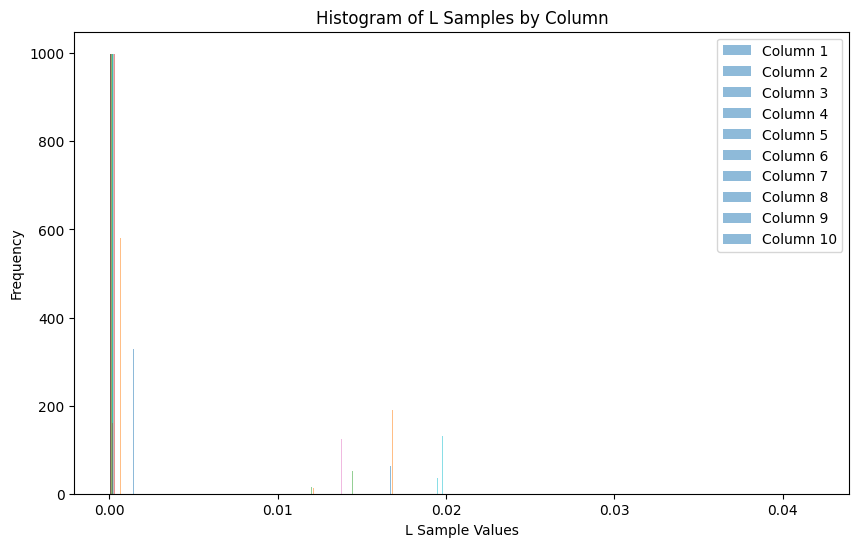

In [ ]:
L = np.array(L)

# Create the histogram
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
num_columns = L.shape[1]
for i in range(num_columns):
    plt.hist(L[:, i], bins=100, alpha=0.5, label=f"Column {i+1}") 

plt.xlabel("L Sample Values")
plt.ylabel("Frequency")
plt.title("Histogram of L Samples by Column")
plt.legend()
plt.show()

### 1.5 - 1.6 Triangle Height and Width for Uncertainty.

Uncomment to use

Sections 1.5 and 1.6 describe how p~ and V* can be used to create Triangular Probability Density functions.

Instead, this notebook will use Normal Functions as Probability Densities instead of Triangular Probability Density functions.

In this implementation, Probability Density Functions are created as follows:

f = (mean, std_dev)  
f = (p*V~, insert here)  
f = clip f between 0 and 1  

This approach creates Probability Density Functions with the following Properties:
* Area under Clipped Normal curve equals to 1
* All values between 0 and 1
* Independence, each expert is independent of others, and each photograph rating is indepdent. In other words, experts don't get smarter / learn as they go and can't peak at other experts to influence their decisions.

The mean (mu) is calculated as mu = p*v~ and the standard deviation  is sqrt (mu * (1-mu) / Num_samples ).  

NB. In the event that p*V~ is very close to 0, or very close 1, it is better to treat this as a certainty than as an uncertainty (see 1.7)


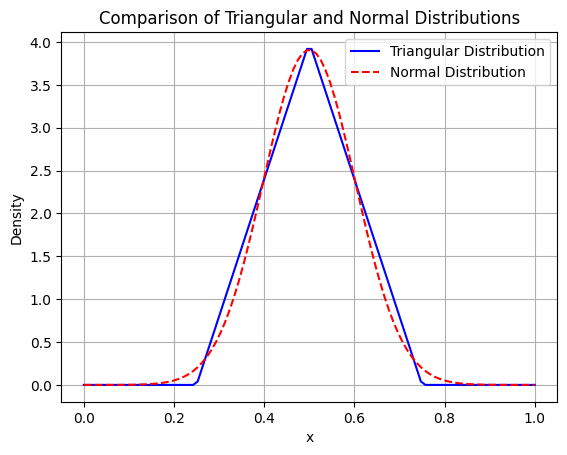

Triangular Distribution Mean: 0.49985973904770353
Triangular Distribution Variance: 0.010432064986924418
Normal Distribution Mean: 0.5000007933324995
Normal Distribution Variance: 0.01040663234982469
Normal Distribution Deviation: 0.10213748081348208


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, triang

# Parameters for the triangular distribution
a, b, c = 0.25, 0.5, 0.75

# Parameters for the normal distribution
mu = b
sigma = np.sqrt( ( a*a + b*b + c*c - a*b -a*c -b*c) /18  )

# Create an array of x values
x = np.linspace(0,1,100)

# Triangular distribution
height = 2 / (c - a)
width = c-a

triangular = triang.pdf(x, (b-a)/(c-a), loc=a, scale=(c-a))

# Normal distribution
normal = norm.pdf(x, mu, sigma)

# Plot the distributions
plt.plot(x, triangular, label='Triangular Distribution', color='blue')
plt.plot(x, normal, label='Normal Distribution', color='red', linestyle='dashed')
plt.title("Comparison of Triangular and Normal Distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Sampling
n_samples = 1_000_000

# Sample from triangular distribution
triangular_samples = np.random.triangular(a, b, c, n_samples)

# Sample from normal distribution
normal_samples = np.random.normal(mu, sigma, n_samples)

# Calculate mean and variance for both samples
triangular_mean = np.mean(triangular_samples)
triangular_variance = np.var(triangular_samples)

normal_mean = np.mean(normal_samples)
normal_variance = np.var(normal_samples)
normal_standarddec = np.sqrt(triangular_variance)

# Print the results
print(f"Triangular Distribution Mean: {triangular_mean}")
print(f"Triangular Distribution Variance: {triangular_variance}")
print(f"Normal Distribution Mean: {normal_mean}")
print(f"Normal Distribution Variance: {normal_variance}")
print(f"Normal Distribution Deviation: {normal_standarddec}")
